### Library

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.preprocessing .image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import datetime
import optuna
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler, GridSampler
from sklearn.manifold import TSNE
from keras.callbacks import TensorBoard
from tqdm import tqdm

### Data

(50000, 32, 32, 3)


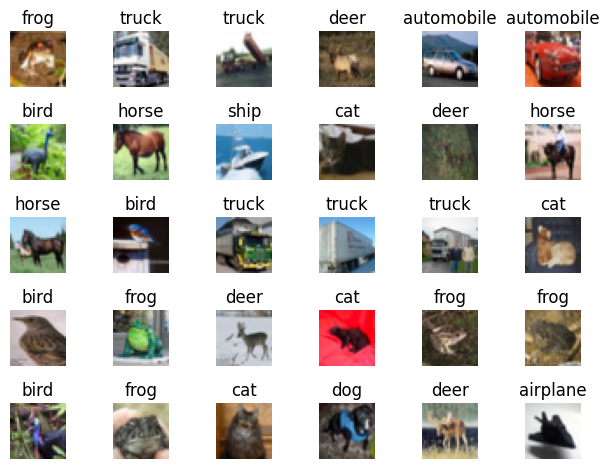

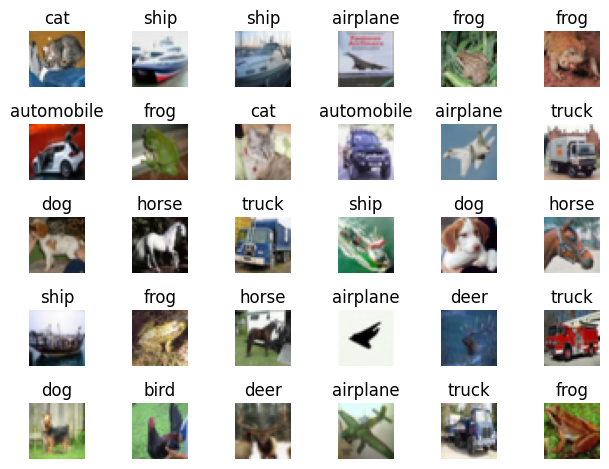

num_class: 10


In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)

#ラベルの設定
labels = np.array([
    'airplane',  #飛行機
    'automobile',#バイク
    'bird',      #鳥
    'cat',       #猫
    'deer',      #鹿
    'dog',       #犬
    'frog',      #カエル
    'horse',     #馬
    'ship',      #船
    'truck'      #トラック
    ])

#画像の表示のための関数
def image_show(x, y, labels):
    for i in range(30):
        plt.subplot(5, 6, i+1)
        #軸を表示しない
        plt.axis("off")
        #タイトルをラベルの名前で表示
        plt.title(labels[y[i][0]])
        #表示
        plt.imshow(x[i])
    plt.tight_layout()
    plt.show()
    return    

# トレーニングデータの画像とラベルをセットで表示してみる
image_show(X_train, y_train, labels)
image_show(X_test, y_test, labels)

# データの前処理
# ラベルをバイナリクラスにする(yの値を10この数値の配列に変換している)
categorical_y_train = to_categorical(y_train, 10)
categorical_y_test = to_categorical(y_test, 10)

# 正解ラベルの中身の種類 (0~9)をlistに格納
class_list = np.unique(y_train).tolist()
num_class = len(class_list)
print("num_class:", num_class)

### CNN

In [8]:
inputs = Input(shape=X_train[0].shape)
x = Conv2D(64, (3,3), padding = "same", activation="relu")(inputs)

for i in range(5):
    x = Conv2D(128/2**(i-1), (3,3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.2)(x)

intermediate_layer = Conv2D(32, (3,3), padding="same", activation="relu")(x)

# 平滑化
x = Flatten()(intermediate_layer)

# 全統合
x = Dense(512, activation="relu")(x)
x = Dropout(0.6)(x)
predictions = Dense(num_class, activation="softmax")(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"]
)

### Log

In [9]:
keras.utils.plot_model(model, to_file="/home/gakubu/デスクトップ/ML_git/MLT/ML_11/trial_model.png", 
                        show_shapes=True, show_layer_activations="True")

# tensorboard を使用
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

### Learn

Epoch 1/10
196/196 [==============================] - 278s 1s/step - loss: 1.7672 - accuracy: 0.3113 - val_loss: 1.7964 - val_accuracy: 0.3450
Epoch 2/10
196/196 [==============================] - 281s 1s/step - loss: 1.3291 - accuracy: 0.5028 - val_loss: 1.2719 - val_accuracy: 0.5448
Epoch 3/10
196/196 [==============================] - 286s 1s/step - loss: 1.1075 - accuracy: 0.6025 - val_loss: 1.5677 - val_accuracy: 0.5042
Epoch 4/10
196/196 [==============================] - 273s 1s/step - loss: 0.9881 - accuracy: 0.6509 - val_loss: 0.9636 - val_accuracy: 0.6541
Epoch 5/10
196/196 [==============================] - 287s 1s/step - loss: 0.9009 - accuracy: 0.6838 - val_loss: 0.9437 - val_accuracy: 0.6613
Epoch 6/10
196/196 [==============================] - 290s 1s/step - loss: 0.8363 - accuracy: 0.7073 - val_loss: 0.9267 - val_accuracy: 0.6806
Epoch 7/10
196/196 [==============================] - 296s 2s/step - loss: 0.7871 - accuracy: 0.7281 - val_loss: 0.8330 - val_accuracy: 0.7062

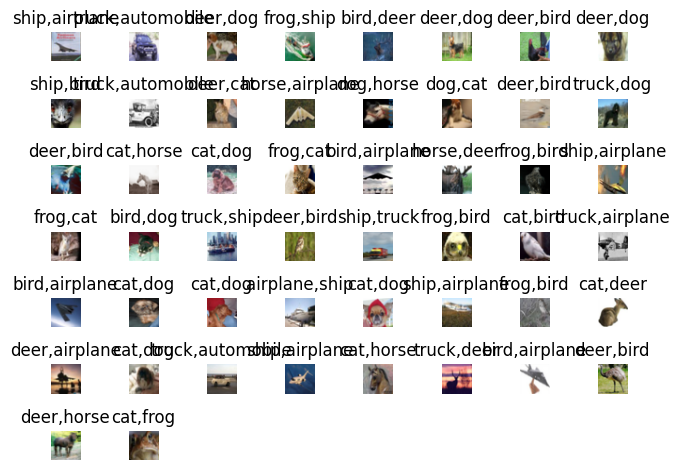

num_correct: 7576
num_valid_samples: 10000
accuracy: 0.7576


In [10]:
model.fit(X_train, categorical_y_train,
        batch_size=256,
        epochs=10,
        verbose=1,
        validation_data=(X_test, categorical_y_test),
        callbacks=[tensorboard_callback, EarlyStopping(patience=10)]
)

# テストデータに対する予測
y_test_pred = model.predict(X_test)
# 予測したものを元のカテゴリクラスに変換する
y_test_pred = np.argmax(y_test_pred, axis=1)
y_test_pred_labels = y_test_pred.reshape(-1, 1)
# データの形を確認
print("y_test_pred_labels:", y_test_pred_labels)
print("y_test:", y_test)
# 予測と正解ラベルが異なる画像のインデックスを取得
misclassified_indices = np.where(y_test_pred != np.argmax(categorical_y_test, axis=1))[0]
print("misclassified_indices:", misclassified_indices)
# 表示する画像の枚数
num_images_to_display = min(50, len(misclassified_indices))
num_miss_categorized = len(misclassified_indices)
print("Num miss categorized:", num_miss_categorized)
# グリッドの行数と列数を計算
num_rows = int(np.sqrt(num_images_to_display))
num_cols = int(np.ceil(num_images_to_display / num_rows))
# 誤分類された画像を表示
for i in range(num_images_to_display):
    index = misclassified_indices[i] 

    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(X_test[index])
    plt.axis("off")
    titles = labels[y_test_pred_labels[index][0]] + "," + labels[y_test[index][0]]
    plt.title(titles)
plt.tight_layout()
plt.show()

# 正解数をカウント
num_correct = len(y_test) - num_miss_categorized

# valid_index の数
num_valid_samples = len(y_test)

# 正解率
print("num_correct:", num_correct)
print("num_valid_samples:", num_valid_samples)
accuracy = num_correct / num_valid_samples
print("accuracy:", accuracy)

In [11]:
# 中間層の出力を取得
intermediate_layer_model = Model(inputs=inputs, outputs=intermediate_layer)
intermediate_output = intermediate_layer_model.predict(X_train)

1563/1563 [==============================] - 57s 36ms/step


### TSNE

In [12]:
print(intermediate_output.shape)
print(intermediate_output.shape[0])
data_for_embedding = intermediate_output.reshape(intermediate_output.shape[0], -1)
print(data_for_embedding.shape)
# t-SNEによる次元削減
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_for_embedding)
print(tsne_result.shape)

(50000, 1, 1, 32)
50000
(50000, 32)
(50000, 2)


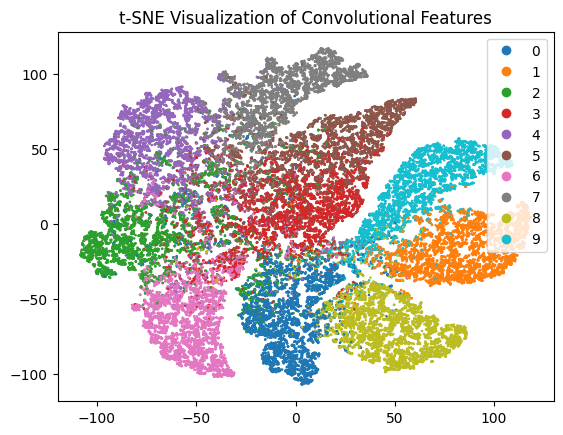

In [13]:
# プロット
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_train.flatten(), cmap="tab10", s=0.7)
plt.legend(*scatter.legend_elements())
plt.title('t-SNE Visualization of Convolutional Features')
plt.show()

### UMAP

In [16]:
import umap

umap = umap.UMAP(random_state=42)
umap_result = umap.fit_transform(data_for_embedding)
print(umap_result.shape)

/home/gakubu/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(50000, 2)


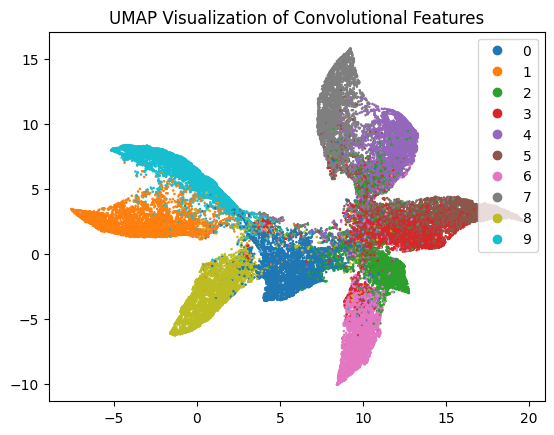

In [17]:
# プロット
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=y_train.flatten(), cmap="tab10", s=0.7)
plt.legend(*scatter.legend_elements())
plt.title('UMAP Visualization of Convolutional Features')
plt.show()